In [9]:
import json
import random

from pathlib import Path
from pylab import cm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd


from layout_gnn.dataset.dataset import RICOSemanticAnnotationsDataset
from layout_gnn.dataset.transformations import *
from layout_gnn.utils import *
from layout_gnn.similarity_metrics import compute_edit_distance, compute_iou
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'
DATA_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
rico_dataset = RICOSemanticAnnotationsDataset(
    transform=transforms.Compose([
        process_data,
        normalize_bboxes,
        add_networkx,
    ]),
    only_data=True
)

In [5]:
dataloader = DataLoader(rico_dataset, batch_size=1, num_workers=16, collate_fn=default_data_collate)
dataset = []

for data in tqdm(dataloader):
    dataset.extend(data)
    
dataset = sorted(dataset, key=lambda x: x['filename'])

  0%|          | 0/65536 [00:00<?, ?it/s]

In [6]:
datapoint_1, datapoint_2 = dataset[200], dataset[1000]

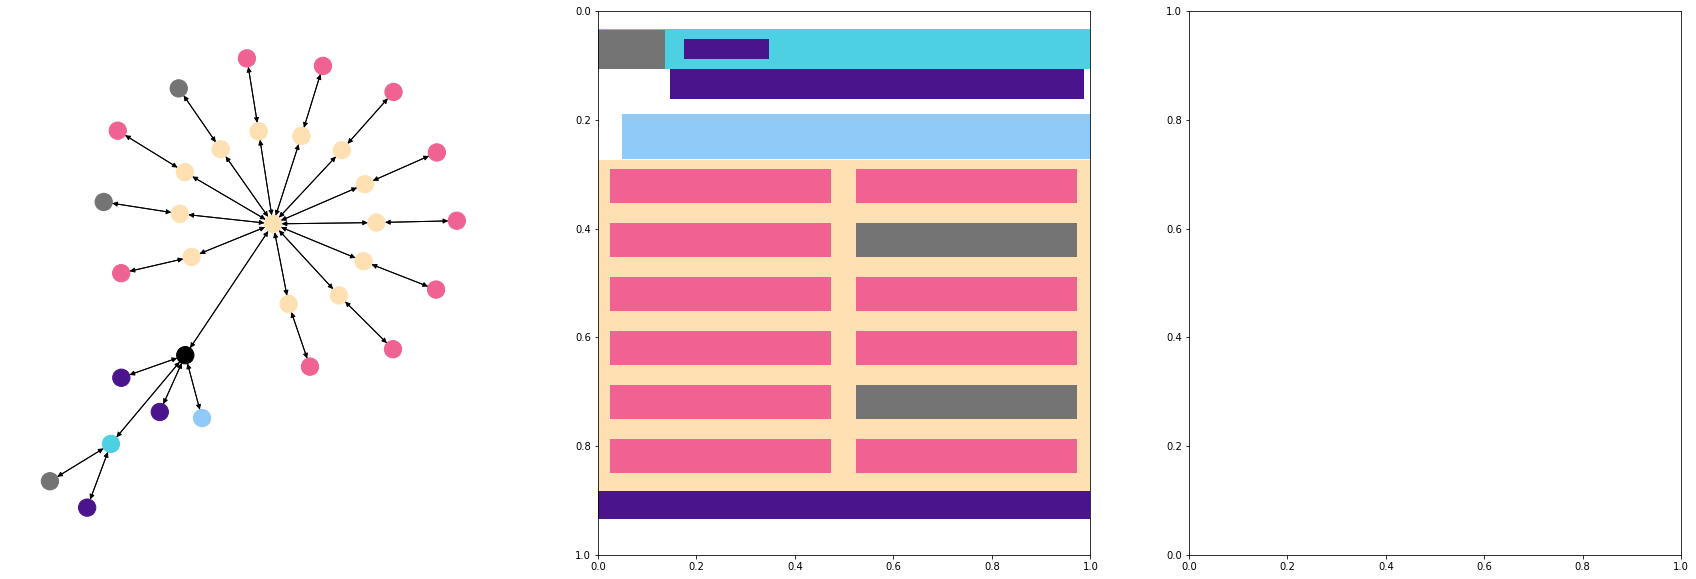

In [7]:
fig = plot_datapoint(datapoint_1, rico_dataset.label_color_map)

In [8]:
datapoint_2['filename']

'10995'

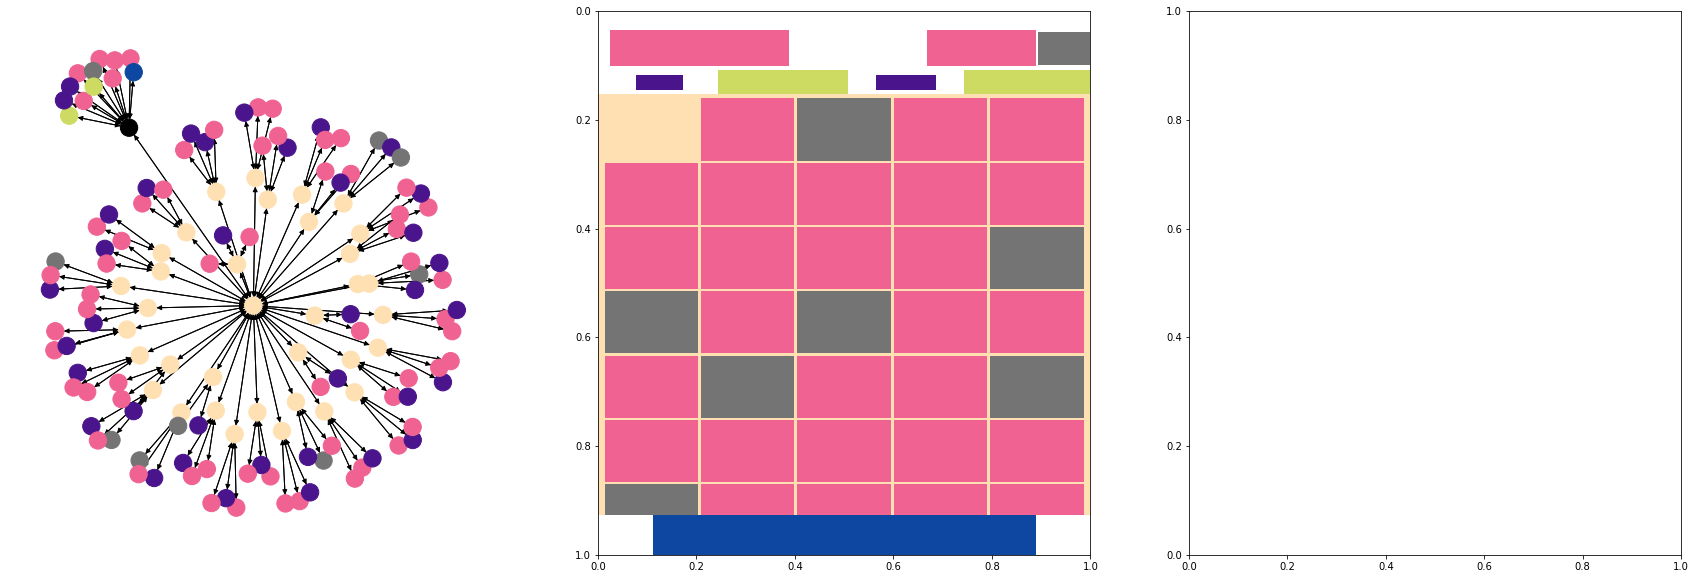

In [9]:
fig = plot_datapoint(datapoint_2, rico_dataset.label_color_map)

## Compute ED between both trees

In [10]:
compute_edit_distance(datapoint_1['graph'].to_undirected(), datapoint_2['graph'].to_undirected())

{'edit_distance': 116.0, 'normalized_edit_distance': 0.651685393258427}

In [11]:
node_labels = sorted(list(set(node['label'] for _, node in datapoint_1['graph'].nodes(data=True)) | set(node['label'] for _, node in datapoint_2['graph'].nodes(data=True))))
node_labels = {label: idx for idx, label in enumerate(node_labels)}
image_shape = (256, 256)

In [12]:
compute_iou(datapoint_1, datapoint_2)

{'iou': 0.6027059845597962}

In [13]:
def compute_pairs(datapoint, dataset, pos_thresh=0.9, neg_thresh=0.1):
    sample = {
            'graph': datapoint['filename'],
    }
    for datapoint2 in dataset:
        iou = compute_iou(datapoint, datapoint2)
        ted = compute_edit_distance(datapoint['graph'].to_undirected(), datapoint2['graph'].to_undirected())
        normalized_ted = 1 - ted['normalized_edit_distance']
        
        if iou['iou'] >= pos_thresh:
            sample['positive_iou'] = {
                'graph': datapoint2['filename'],
                **iou
            }
        if iou['iou'] <= neg_thresh:
            sample['negative_iou'] = {
                'graph': datapoint2['filename'],
                **iou
            }
            
        if normalized_ted >= pos_thresh:
            sample['positive_ged'] = {
                'graph': datapoint2['filename'],
                **ted
            }
        if normalized_ted <= neg_thresh:
            sample['negative_ged'] = {
                'graph': datapoint2['filename'],
                **ted
            }
            
        if 'positive_iou' in sample and 'negative_iou' in sample and 'positive_ged' in sample and 'negative_ged' in sample:
            break
        
        return sample

In [14]:
def compute_distances(datapoint1, dataset):
    distances = []
    for datapoint2 in random.choices(dataset, k=100):
        iou = compute_iou(datapoint1, datapoint2)
        ted = compute_edit_distance(datapoint1['graph'].to_undirected(), datapoint2['graph'].to_undirected())
        distances.append({
           **iou,
           **ted
        })
        
    return distances

In [15]:
final_distances = Parallel(n_jobs=16)(delayed(compute_distances)(datapoint1, dataset) for datapoint1 in tqdm(random.choices(dataset, k=100), total=100))

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
final_distances = [f_point for f in final_distances for f_point in f]

<AxesSubplot:ylabel='Frequency'>

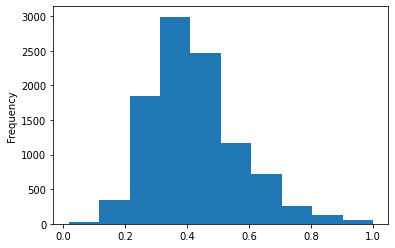

In [17]:
pd.DataFrame(final_distances)['iou'].plot.hist()

In [20]:
pd.DataFrame(final_distances)['iou'].describe(percentiles=[.1, .25, .5, .75, .9])

count    10000.000000
mean         0.423266
std          0.145410
min          0.018361
10%          0.261462
25%          0.322241
50%          0.404293
75%          0.498676
90%          0.627246
max          1.000000
Name: iou, dtype: float64

<AxesSubplot:ylabel='Frequency'>

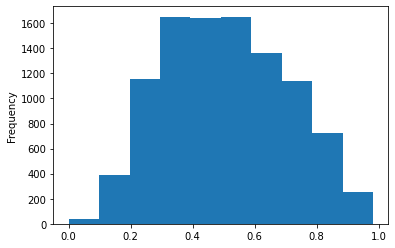

In [18]:
pd.DataFrame(final_distances)['normalized_edit_distance'].plot.hist()


In [22]:
pd.DataFrame(final_distances)['normalized_edit_distance'].describe(percentiles=[.1, .25, .5, .75, .9])


count    10000.000000
mean         0.507154
std          0.196827
min          0.000000
10%          0.250000
25%          0.353387
50%          0.500000
75%          0.659212
90%          0.782051
max          0.982143
Name: normalized_edit_distance, dtype: float64